# Подготовка данных для модели оценки заголовка

Введенные или сгенерированные заголовки нужно как-то оценивать. Так как главной целью обычно является увеличение количества просмотров, то в качестве критерия нужно использовать число просмотров у ранее опубликованных статей. То есть перед нами стоит задача **регрессии**: на входе заголовок, на выходе число (балл от 0.0 до 10.0 с точностью 0.1).

In [1]:
import warnings
warnings.filterwarnings('ignore')

# standard libraries
import gc
import pickle
import io

# data processing libraries
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

# make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

# data processing progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# пути к датасетам
DATASETS_PATH = "/home/leo/DATASETS"

# общий для приложений словарь с источником данных и их характеристиками
with open('../sources.pickle', 'rb') as f:
    sources = pickle.load(f)

%matplotlib inline

# Подготовка данных
## 1. Соединение датафреймов

В нашем распоряжении имеется множество данных, полученных в результате парсинга. Объединим их в один большой датасет для построения модели оценки заголовков. Для построения будем использовать те датасеты (сайты), которые содержат информацию о количестве просмотров статей.

In [2]:
# соединяем датасеты в один общий датасет с именем df
dfs = dict()

for source in sources:
    dfs[source] = pd.read_csv(f"{DATASETS_PATH}/{source}.csv",
                              index_col=0,
                              parse_dates=['post_time', 'parse_time'])
    dfs[source]['source'] = source
    
df = pd.concat(dfs[key] for key in dfs)

# преобразуем количество просмотров
df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# удаляем закрытые и недоступные статьи
df = df.drop(df[df.views_num == 0.0].index)

# удаляем дубликаты
df = df.drop_duplicates()
df = df.loc[~df.index.duplicated(keep='last')]
df.head()

,title,post_time,short_text,views_num,parse_time,filename,source,likes_num,favs_num,comments_num
https://tproger.ru/articles/kak-bystro-razvernut-hranilishhe-i-analitiku-dannyh-dlja-biznesa/,Как быстро развернуть хранилище и аналитику да...,2021-03-01 12:32:23+03:00,Сегодня хочу рассказать историю проекта по зап...,7825,2021-03-14,59a7ab25-11f7-502a-b63a-bbdcb121f488,tproger,NaN,NaN,NaN
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,2021-03-01 09:05:11+03:00,Для начинающего разработчика очень важно не то...,6741,2021-03-14,80f10716-5243-55ca-a67d-4dfe77cd27a5,tproger,NaN,NaN,NaN
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",2021-02-26 19:39:50+03:00,Сегодня нейронные сети используются в сельском...,4032,2021-03-14,aaffd2c5-592f-5d7b-b972-95073d0da49a,tproger,NaN,NaN,NaN
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,2021-02-26 17:29:00+03:00,Сразу хочется пошутить и предложить разработат...,1121,2021-03-14,16f80dbb-8e7c-5a5b-9025-b2fdef30bfd0,tproger,NaN,NaN,NaN
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,2021-02-26 15:16:46+03:00,Профиль задач quality engineer (QE) достаточно...,187,2021-03-14,9d58bde6-7aaf-57a4-b381-25171b9a368f,tproger,NaN,NaN,NaN


In [ ]:
# Добавить дату парсинга к остальным датасетам, для небольших можно адаптировать и извлечение текста

## 2. Коррекция случаев заниженного числа просмотров
Число просмотров на сайтах иногда существуенно отстает от предполагаемого или не всегда корректно рассчитано. Особенно это заметно на когда количество просмотров меньше числа лайков и добавлений в избранные статьи. Чтобы скорректировать такие значения, построим простую  регрессионную SGD-модель на данных, внушающих доверие и экстраполируем результат на «подозрительные» данные о числе просмотров.

In [3]:
df['post_time'] = pd.to_datetime(df['post_time'], utc=True)
df['mln_secs_to_now'] = (pd.Timestamp.now(tz='UTC') - df['post_time']).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num']].dropna()
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]
df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])
df.update(df_tmp)

## 3. Преобразование целевой переменной: от числа просмотров к рейтингу
Оставим только данные, которые используются для построения модели: текст заголовка (`X`) и число просмотров (`y`). Отсортируем статьи по количеству просмотров и зададим для каждой позиции рейтинг `score`, равномерно распределенных между 0 для непросматриваемой статьи и 100 для самой просматриваемой. Таким образом, оценка в 90 означает, что подобные заголовки имели не меньшее число просмотров, чем 90% иследованного набора данных. Впоследствии эти баллы будут использоваться для отображения шкалы 0-100 в 0.0-10.0.

In [109]:
Xy = df[['title', 'views_num']]
Xy['title'] = Xy['title'].apply(str)
#max_title_length = Xy.title.apply(len).max()
Xy.sort_values(by='views_num', inplace=True)

bound = round(Xy.shape[0]*0.2)
Xy['score'] = 0
Xy.score.iloc[-bound:] = 1
Xy['score'] = Xy['score'].astype('int8')
Xy.drop(columns='views_num', inplace=True)

In [110]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229192 entries, https://habr.com/ru/post/81826 to https://habr.com/ru/post/491974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   229192 non-null  object
 1   score   229192 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 3.7+ MB


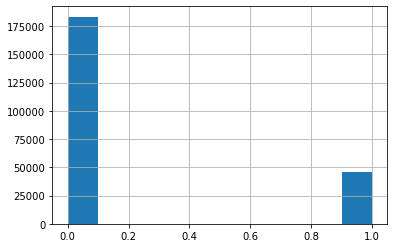

In [111]:
Xy.score.hist()

In [112]:
Xy.to_pickle('Xy.pickle', compression='gzip', protocol=4)

# XXX Archive & Drafts XXX

In [ ]:
# парсинг сайтов с помощью расширения web scrapy

# import datetime

# df_tmp = pd.read_csv(f'{DATASETS_PATH}/xakep.csv')
# df_tmp = df_tmp.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_tmp = df_tmp.set_index('title-href')
# #df_tmp = df_tmp.fillna(0)

# def find_digit(s):
#     digit_string = re.findall(r'\d+', s)
#     if digit_string:
#         return int(digit_string[0])
#     else:
#         return 0

# df_tmp.comments_num = df_tmp.comments_num.apply(find_digit)
# df_tmp['parse_time'] = datetime.datetime.now()
# df_tmp['comments_num'] = df_tmp['comments_num'].replace('Обсудить', '0')
# df_tmp['comments_num'] = df_tmp['comments_num'].astype('int8')
# df_tmp['likes_num'] = df_tmp['likes_num'].astype('int8')
# df_tmp['favs_num'] = df_tmp['favs_num'].astype('int8')
# df_tmp.set_index('url-href').to_csv(f'{DATASETS_PATH}/thecode.csv')

In [ ]:
# генерация дополнительных признаков
# Xy.loc[:, ['title']] = Xy.title.apply(str)

# Xy.loc[:, ['doc']] = Xy.title.progress_apply(nlp)

# длина заголовка в символах
# Xy.loc[:, ['len']] = Xy.title.apply(len)

# количество токенов
# Xy.loc[:, ['tokens_num']] = Xy.tokens.apply(lambda x: len(x))

# Токенизация большого числа заголовков — затратная по времени операция.
# Поэтому предварительно токенизированные заголовки хранятся в виде
# сжатого датафрайма
#tokenized_titles = pd.read_pickle(TOKENIZED_TITLES_PATH, compression='gzip')

# for i in [3, 8, 9]:
#     spacy.displacy.render(tokenized_titles.iloc[i], style='ent', jupyter=True)

# tokenized_titles.to_pickle(path=TOKENIZED_TITLES_PATH, compression='gzip')